In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_theme()


In [2]:
df = pd.read_csv("cleaned.csv")
df["product"].unique()

array(['Кредитные карты', 'Страхование', 'Дебетовые карты',
       'Бизнес-продукты', 'Залоговые кредиты',
       'Инвестиции и брокерские счета', 'Не определено',
       'Потребительские кредиты наличными', 'Премиальные продукты',
       'Автокредиты', 'Lifestyle-сервисы',
       'Рассрочка и кредиты в покупках', 'Мобильная связь', 'Подписки',
       'Ипотека и ипотечное рефинансирование', 'Банкоматы',
       'Вклады и накопительные продукты', 'Проблемная задолженность'],
      dtype=object)

In [3]:
default_figsize = (12, 10)

def preprocess_data(df_raw):
    df = df_raw.copy()
    
    df["review_dttm"] = pd.to_datetime(df["review_dttm"], errors='coerce')
    df["finish_dttm"] = pd.to_datetime(df["finish_dttm"], errors='coerce')
    
    df["review_week"] = df["review_dttm"].dt.to_period("W").dt.to_timestamp()
    
    credit_products = [
        "Кредитные карты", 
        "Потребительские кредиты наличными", 
        "Автокредиты", 
        "Рассрочка и кредиты в покупках", 
        "Ипотека и ипотечное рефинансирование", 
        "Залоговые кредиты", 
        "Проблемная задолженность"
    ]
    df["is_credit_product"] = df["product"].apply(lambda x: x in credit_products)
    
    return df

def plot_context(df, product_df, product_name):
    plt.figure(figsize=default_figsize)

    c = product_df.groupby("review_week")["review_mark"].mean().reset_index()

    creds = df[df["is_credit_product"]]
    all_credit_products = creds.groupby("review_week")["review_mark"].mean().reset_index()
    all_products = df.groupby("review_week")["review_mark"].mean().reset_index()

    sns.lineplot(data=c, x="review_week", y="review_mark", label=product_name, linewidth=2)
    sns.lineplot(data=all_credit_products, x="review_week", y="review_mark", label="Все кредитные продукты", linewidth=2, linestyle='--', alpha=0.7)
    sns.lineplot(data=all_products, x="review_week", y="review_mark", label="Все продукты", linewidth=2, linestyle='--', alpha=0.7)

    for week in c["review_week"]:
        plt.axvline(x=week, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
        
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{product_name}: Comparison with Market Trends", fontsize=14)
    plt.legend()
    plt.show()

def plot_volume_mark(product_df, product_name):
    c = product_df.groupby("review_week")["review_mark"].mean().reset_index()
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    sns.lineplot(data=c, x="review_week", y="review_mark", label="Average Mark", color="tab:blue", ax=ax1, linewidth=3)
    ax1.set_ylabel("Average Mark", color="tab:blue", fontsize=12)
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.set_ylim(1, 5.5)

    ax2 = ax1.twinx()
    weekly_counts = product_df.groupby("review_week").size().reset_index(name="count")

    ax2.bar(weekly_counts["review_week"], weekly_counts["count"], color="gray", alpha=0.3, width=6, label="Review Volume")
    ax2.set_ylabel("Number of Reviews", color="gray", fontsize=12)
    ax2.tick_params(axis='y', labelcolor="gray")

    plt.title(f"{product_name}: Review Volume vs. Average Mark over Time", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_reason_dynamics(product_df, product_name, top_n=7):
    if product_df['reason'].dropna().empty:
        print("No reason data available for dynamics plot.")
        return

    top_reasons = product_df['reason'].value_counts().head(top_n).index.tolist()
    cards_filtered = product_df[product_df['reason'].isin(top_reasons)]

    if cards_filtered.empty:
        print("Not enough data for reason dynamics.")
        return

    reason_trends = pd.crosstab(cards_filtered['review_week'], cards_filtered['reason'])

    ax = reason_trends.plot(kind='area', stacked=True, alpha=0.6, figsize=default_figsize, colormap='tab10')

    plt.title(f"Dynamics of Top Reasons for Feedback ({product_name})", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.legend(title="Reason", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_reason_marks(product_df, product_name, min_reviews=10):
    cards_with_reasons = product_df[product_df['reason'] != 'Не определено'].dropna(subset=['reason'])

    if cards_with_reasons.empty:
        print("No defined reasons available for analysis.")
        return

    reason_marks = (
        cards_with_reasons.groupby('reason')
        .agg(avg_mark=('review_mark', 'mean'), count=('review_mark', 'size'))
        .reset_index()
        .sort_values('avg_mark')
    )

    reason_marks = reason_marks[reason_marks['count'] >= min_reviews]
    
    if reason_marks.empty:
        print(f"Not enough data (>= {min_reviews} reviews per reason) for reason mark analysis.")
        return

    plt.figure(figsize=default_figsize)
    sns.barplot(data=reason_marks, y='reason', x='avg_mark', palette='RdYlGn_r', hue="reason", legend=False, orient='h')
    plt.axvline(x=reason_marks['avg_mark'].mean(), color='black', linestyle='--', alpha=0.5, label='Overall Avg')
    plt.xlabel("Average Review Mark", fontsize=12)
    plt.ylabel("")
    plt.title(f"Average Review Mark by Complaint Reason ({product_name})", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_product_pipeline(df_raw, product_name):    
    df = preprocess_data(df_raw)
    
    product_df = df[df['product'] == product_name].copy()
    
    if len(product_df) == 0:
        print(f"No data found for product: {product_name}")
        return
        
    print(f"Found {len(product_df)} reviews for {product_name}")
    
    plot_context(df, product_df, product_name)
    plot_volume_mark(product_df, product_name)
    plot_reason_dynamics(product_df, product_name)
    plot_reason_marks(product_df, product_name)
    

Found 3065 reviews for Кредитные карты


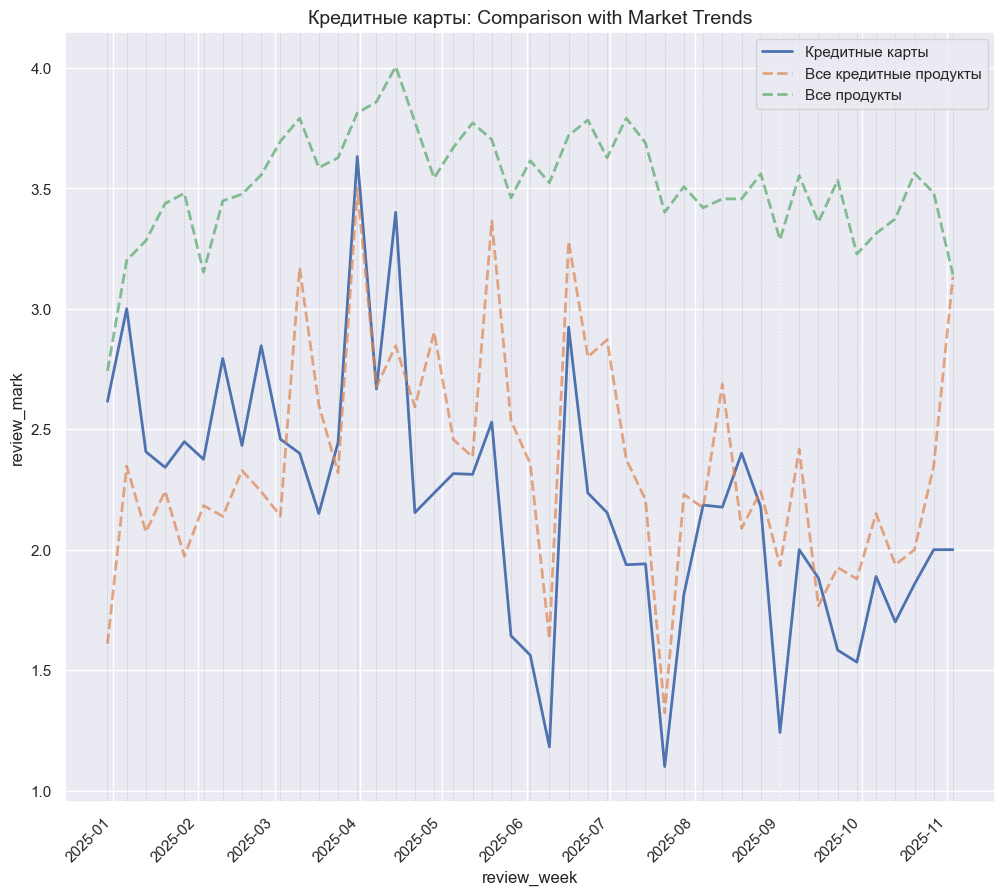

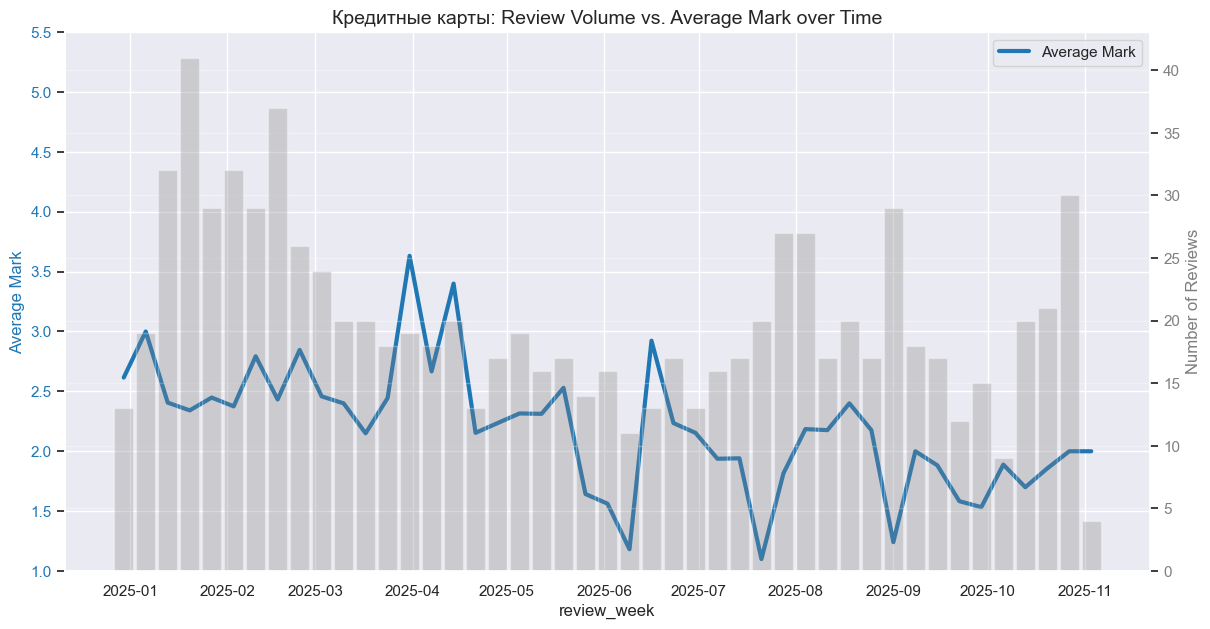

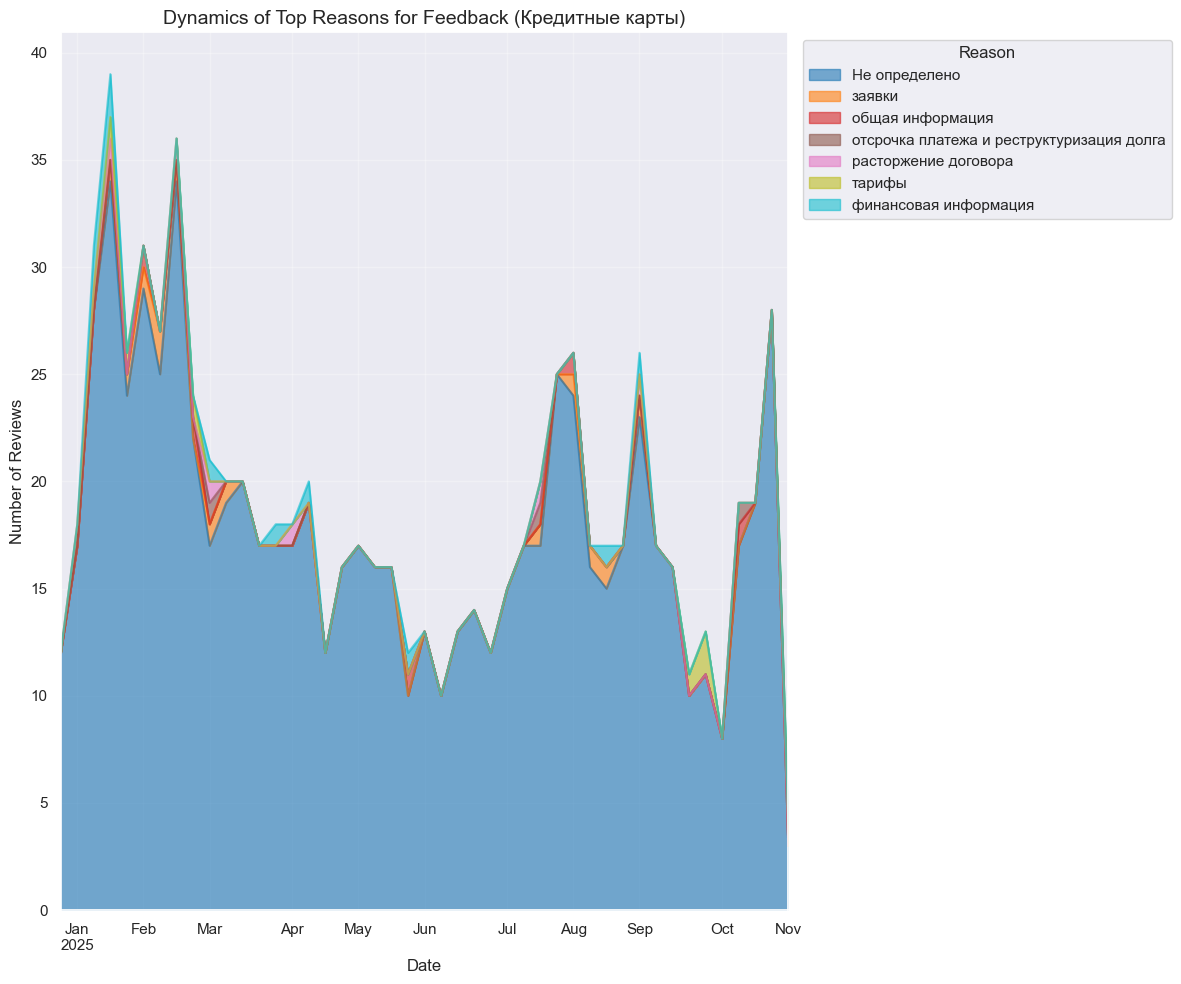

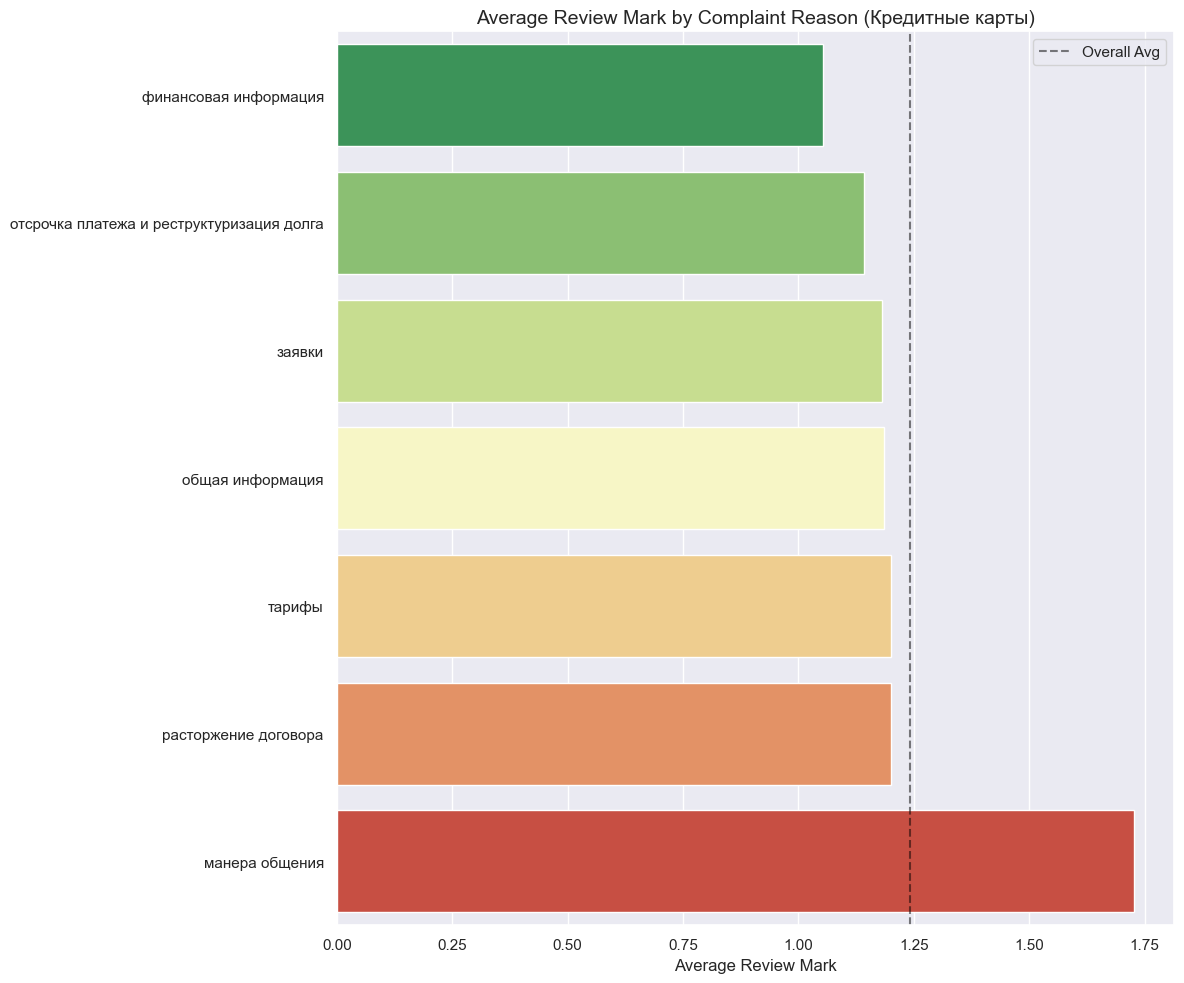

In [4]:
analyze_product_pipeline(df, "Кредитные карты")

In [5]:
def plot_credit_market_overview(df):
    product_stats = (
        df.groupby(['product', 'is_credit_product'])['review_emotion']
          .agg(share_positive='mean', count='size')
          .reset_index()
    )
    
    cred_stats = product_stats[product_stats["is_credit_product"]]
    
    if cred_stats.empty:
        print("No credit products found for market overview.")
        return

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=cred_stats, x="count", y="share_positive", hue="product", s=100)

    for idx, row in cred_stats.iterrows():
        plt.annotate(row['product'], 
                     (row['count'], row['share_positive']),
                     xytext=(7, -7),
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.7)
                     
    plt.title("Credit Products: Positive Share vs. Review Volume", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_category_distribution(df):
    plt.figure(figsize=(10, 6))
    
    plot_df = df.copy()
    plot_df['Product Type'] = plot_df['is_credit_product'].map({True: 'Credit Products', False: 'Other Products'})

    sns.violinplot(data=plot_df, x='Product Type', y='review_mark', palette="muted")
    plt.title("Distribution of Review Marks: Credit vs. Other Products", fontsize=14)
    plt.xlabel("")
    plt.ylabel("Review Mark")
    plt.show()

def plot_credit_product_ranking(df):
    creds = df[df["is_credit_product"]]
    
    if creds.empty:
        print("No credit products data available for ranking.")
        return

    credit_product_marks = (
        creds.groupby('product')
        .agg(
            avg_mark=('review_mark', 'mean'),
            median_mark=('review_mark', 'median'),
            count=('review_mark', 'size')
        )
        .reset_index()
        .sort_values('avg_mark')
    )

    fig, ax = plt.subplots(figsize=(12, 8))

    x_pos = range(len(credit_product_marks))
    width = 0.35

    bars1 = ax.barh([i - width/2 for i in x_pos], credit_product_marks['avg_mark'], 
                    width, label='Average Mark', color='skyblue', alpha=0.8)
    bars2 = ax.barh([i + width/2 for i in x_pos], credit_product_marks['median_mark'], 
                    width, label='Median Mark', color='orange', alpha=0.8)

    ax.set_yticks(x_pos)
    ax.set_yticklabels(credit_product_marks['product'])
    ax.set_xlabel('Review Mark', fontsize=12)
    ax.set_title('Average vs Median Review Marks Across Credit Products', fontsize=14)
    ax.legend()
    ax.axvline(x=3, color='red', linestyle='--', alpha=0.5, label='Neutral (3)')
    plt.tight_layout()
    plt.show()

def analyze_general_stats_pipeline(df_raw):
    if 'preprocess_data' not in globals():
        print("Error: 'preprocess_data' function is not defined. Please run the cell defining it first.")
        return
        
    df = preprocess_data(df_raw)
    
    plot_credit_market_overview(df)
    plot_category_distribution(df)
    plot_credit_product_ranking(df)

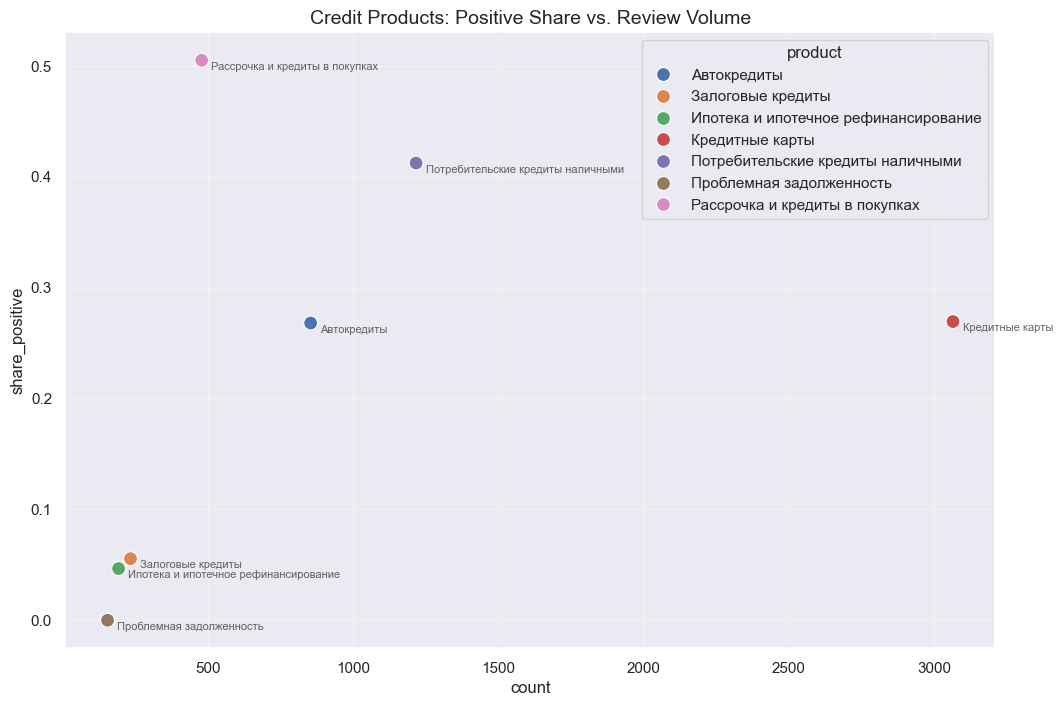

/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_90420/3475053233.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Product Type', y='review_mark', palette="muted")


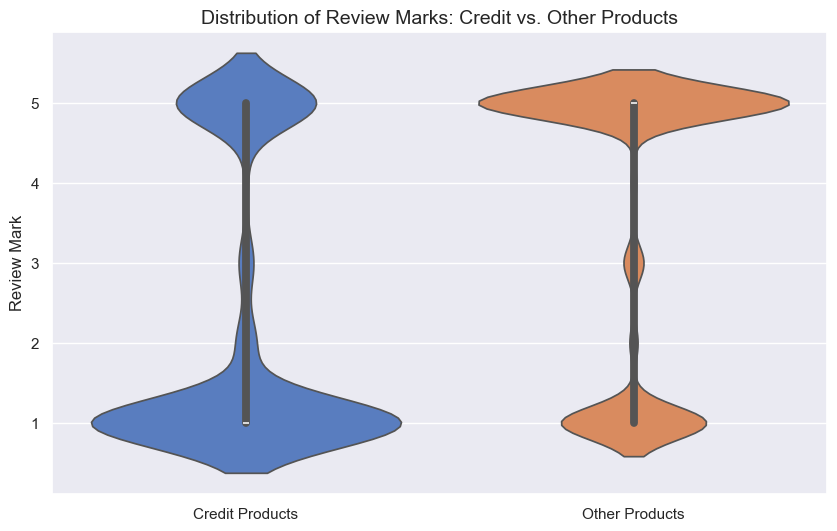

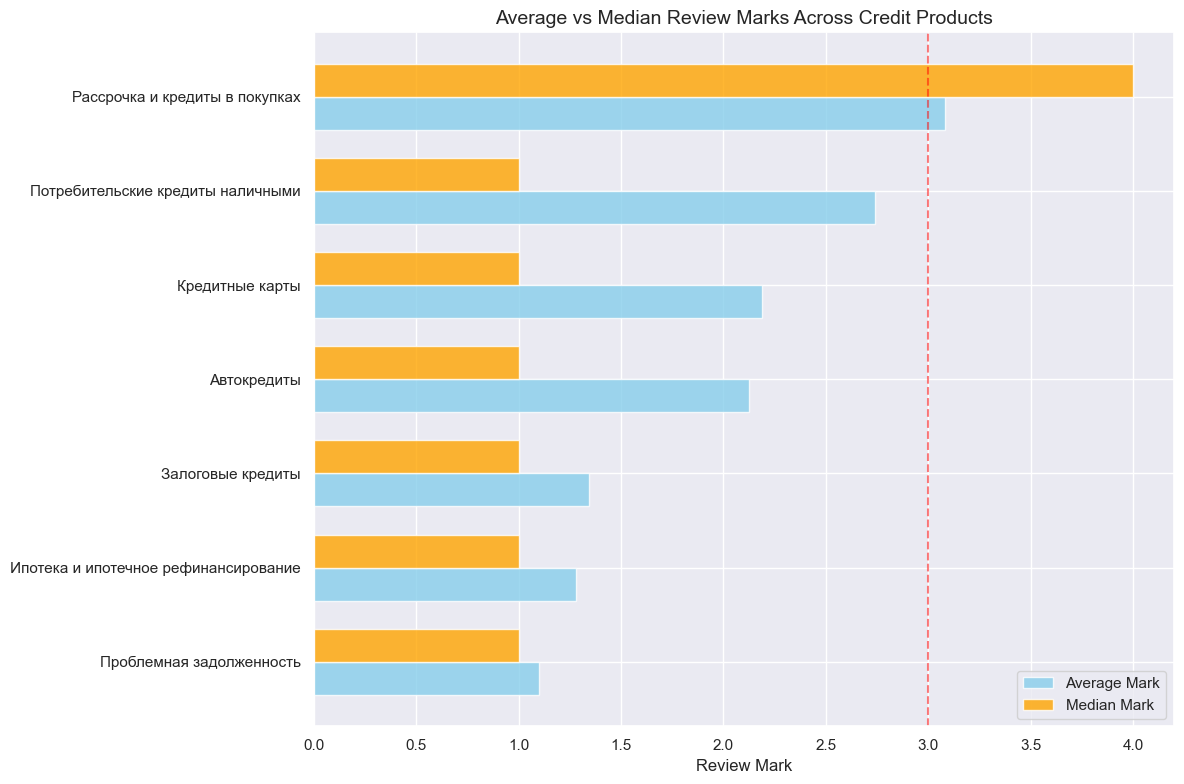

In [6]:
analyze_general_stats_pipeline(df)

In [7]:
def plot_comparison_mark_trends(df, product_a, product_b):
    comparison_df = df[df['product'].isin([product_a, product_b])].copy()
    
    if comparison_df.empty:
        print("No data found for the specified products.")
        return

    trend_data = comparison_df.groupby(["review_week", "product"])["review_mark"].mean().reset_index()

    plt.figure(figsize=(14, 8))
    sns.lineplot(data=trend_data, x="review_week", y="review_mark", hue="product", linewidth=2.5, palette=["tab:blue", "tab:orange"])
    
    plt.title(f"Review Mark Trends: {product_a} vs {product_b}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Average Review Mark")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Product")
    plt.show()

def plot_comparison_volume_vs_mark(df, product_a, product_b):
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    products = [product_a, product_b]
    colors = ["tab:blue", "tab:orange"]
    
    for i, product in enumerate(products):
        ax1 = axes[i]
        product_df = df[df['product'] == product]
        
        if product_df.empty:
            ax1.text(0.5, 0.5, f"No data for {product}", ha='center', va='center')
            continue

        weekly_stats = product_df.groupby("review_week").agg(
            avg_mark=('review_mark', 'mean'),
            count=('review_mark', 'size')
        ).reset_index()

        sns.lineplot(data=weekly_stats, x="review_week", y="avg_mark", color=colors[i], ax=ax1, linewidth=2.5, label="Average Mark")
        ax1.set_ylabel("Average Mark", color=colors[i], fontsize=10)
        ax1.tick_params(axis='y', labelcolor=colors[i])
        ax1.set_ylim(1, 5.5)
        ax1.set_title(f"{product}: Volume vs Mark Dynamics", fontsize=12)
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        ax2.bar(weekly_stats["review_week"], weekly_stats["count"], color="gray", alpha=0.3, width=6, label="Review Volume")
        ax2.set_ylabel("Number of Reviews", color="gray", fontsize=10)
        ax2.tick_params(axis='y', labelcolor="gray")
            
    plt.tight_layout()
    plt.show()

def plot_comparison_reason_dynamics(df, product_a, product_b):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)
    
    products = [product_a, product_b]
    
    for i, product in enumerate(products):
        ax = axes[i]
        product_df = df[df['product'] == product]
        
        if product_df.empty or product_df['reason'].dropna().empty:
            ax.text(0.5, 0.5, f"No reason data for {product}", ha='center', va='center')
            continue

        top_reasons = product_df['reason'].value_counts().head(7).index.tolist()
        filtered_df = product_df[product_df['reason'].isin(top_reasons)]
        
        if filtered_df.empty:
            ax.text(0.5, 0.5, f"Not enough data for {product}", ha='center', va='center')
            continue

        reason_trends = pd.crosstab(filtered_df['review_week'], filtered_df['reason'])
        
        reason_trends.plot(kind='area', stacked=True, alpha=0.6, ax=ax, colormap='tab10')
        ax.set_title(f"Reason Dynamics: {product}", fontsize=12)
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of Reviews")
        ax.legend(loc='upper left', fontsize='small')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_comparison_reason_marks(df, product_a, product_b):
    comparison_df = df[
        (df['product'].isin([product_a, product_b])) & 
        (df['reason'] != 'Не определено')
    ].dropna(subset=['reason'])
    
    if comparison_df.empty:
        print("No reason data available for comparison.")
        return

    top_reasons = comparison_df['reason'].value_counts().head(10).index.tolist()
    
    final_df = comparison_df[comparison_df['reason'].isin(top_reasons)]
    
    reason_stats = (
        final_df.groupby(['reason', 'product'])
        .agg(avg_mark=('review_mark', 'mean'), count=('review_mark', 'size'))
        .reset_index()
    )
    
    reason_stats = reason_stats[reason_stats['count'] >= 5]

    plt.figure(figsize=(12, 10))
    sns.barplot(data=reason_stats, y='reason', x='avg_mark', hue='product', palette=["tab:blue", "tab:orange"], orient='h')
    
    plt.axvline(x=3, color='red', linestyle='--', alpha=0.5, label='Neutral (3)')
    plt.title(f"Average Mark by Top Reasons: {product_a} vs {product_b}", fontsize=14)
    plt.xlabel("Average Review Mark")
    plt.ylabel("Reason")
    plt.legend(title="Product")
    plt.tight_layout()
    plt.show()

def compare_products_pipeline(df_raw, product_a, product_b):
    if 'preprocess_data' not in globals():
        print("Error: 'preprocess_data' function is not defined. Please run the cell defining it first.")
        return
        
    df = preprocess_data(df_raw)
    
    available_products = df['product'].unique()
    if product_a not in available_products:
        print(f"Error: {product_a} not found in dataset.")
        return
    if product_b not in available_products:
        print(f"Error: {product_b} not found in dataset.")
        return

    plot_comparison_mark_trends(df, product_a, product_b)
    plot_comparison_volume_vs_mark(df, product_a, product_b)
    plot_comparison_reason_dynamics(df, product_a, product_b)
    plot_comparison_reason_marks(df, product_a, product_b)

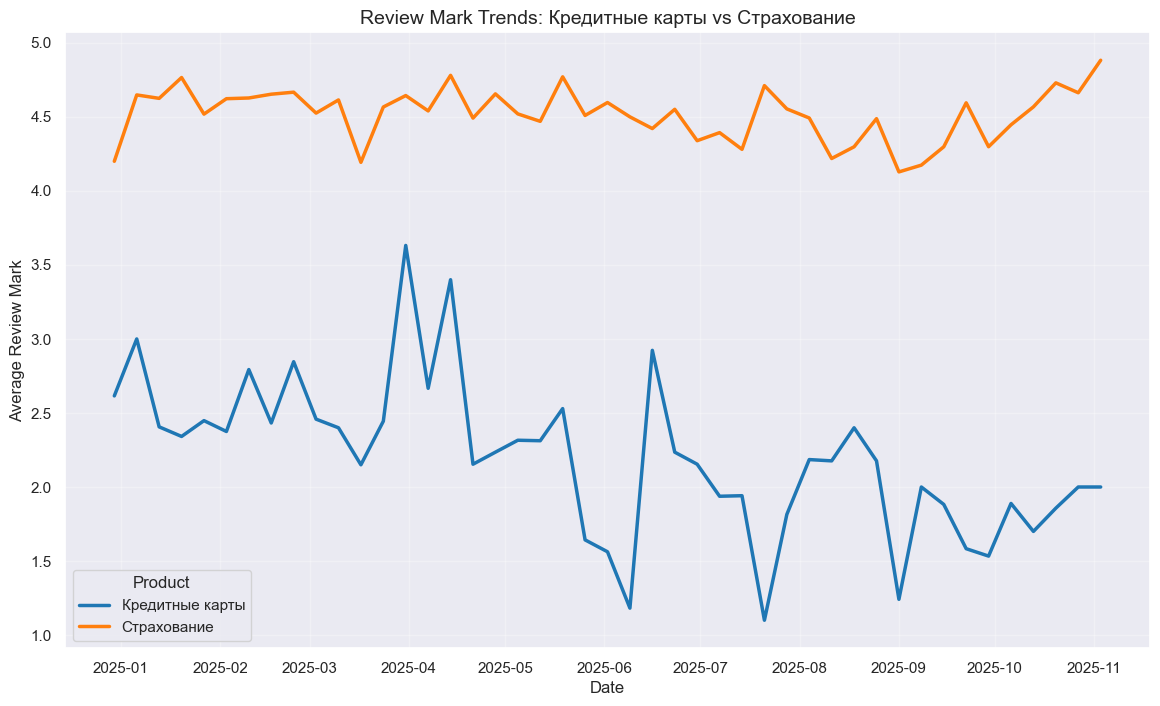

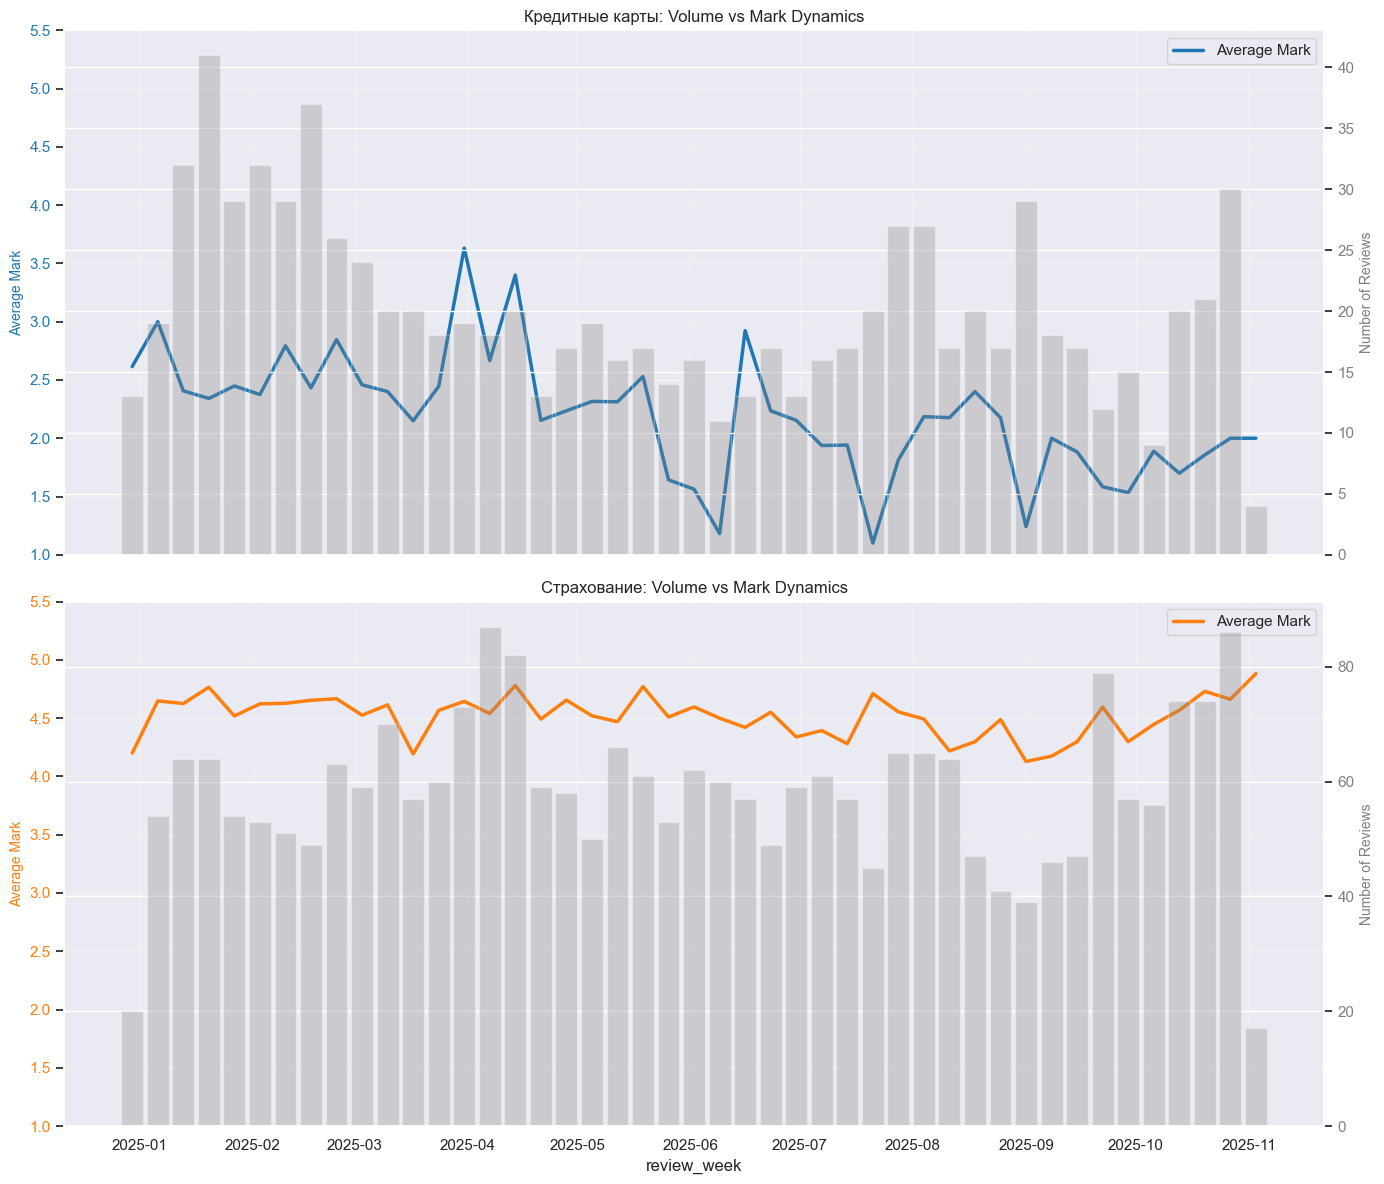

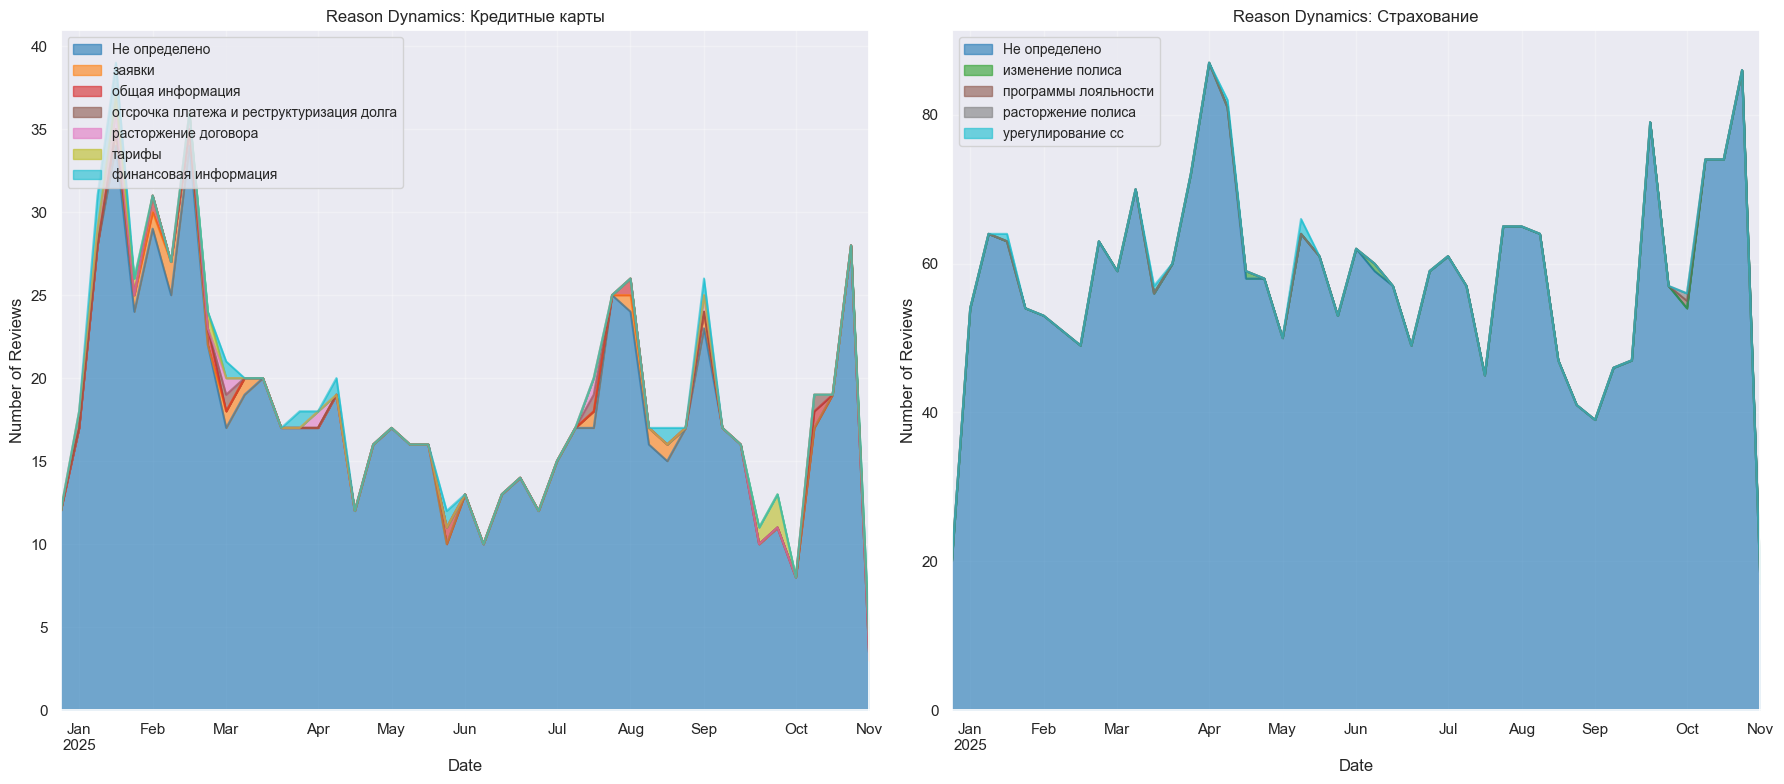

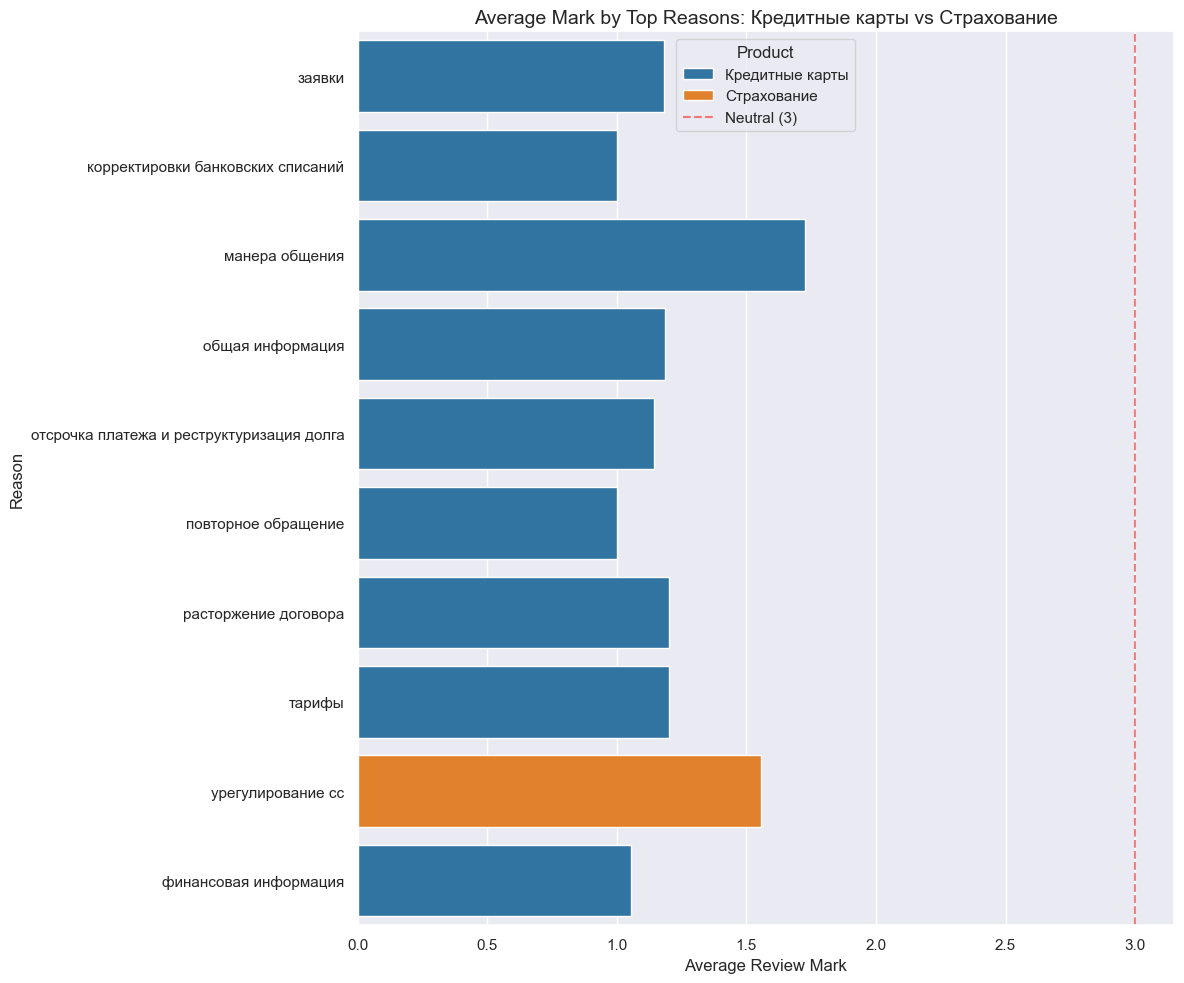

In [8]:
compare_products_pipeline(df, "Кредитные карты", "Страхование")

In [9]:
def credit_products_overview(df_raw):
    df = preprocess_data(df_raw)
    creds = df[df["is_credit_product"]].copy()
    
    creds["handle_hours"] = (
        (creds["finish_dttm"] - creds["review_dttm"])
        .dt.total_seconds() / 3600
    )
    
    summary = (
        creds
        .groupby("product")
        .agg(
            reviews=("review_mark", "size"),
            neg_share=("review_emotion", lambda s: 1 - s.mean()),
            csat_mean=("csat_score", "mean"),
            solved_share=("solution_flg",
                          lambda s: (s == "проблема решена").mean()),
            handle_median=("handle_hours", "median"),
        )
        .reset_index()
        .sort_values("neg_share", ascending=False)
    )
    return summary

In [10]:
def plot_neg_share_by_category(df_raw, product_name, column):
    df = preprocess_data(df_raw)
    product_df = df[df["product"] == product_name].copy()
    
    product_df = product_df.dropna(subset=[column])
    
    stats = (
        product_df
        .groupby(column)["review_emotion"]
        .agg(
            neg_share=lambda s: 1 - s.mean(),
            n="size"
        )
        .reset_index()
    )
    
    stats["category"] = stats[column].astype(str)
    
    stats = stats.sort_values("neg_share", ascending=False)
    
    height = 0.4 * len(stats) + 2
    fig, ax = plt.subplots(figsize=(8, height))
    
    sns.barplot(
        data=stats,
        x="neg_share",
        y="category",
        orient="h",
        ax=ax
    )
    
    ax.set_xlim(0, 1)
    ax.set_xlabel("Доля негативных отзывов")
    ax.set_ylabel("")
    ax.set_title(f"{product_name}: доля негатива по {column}")
    ax.grid(axis="x", alpha=0.3)
    
    for i, (v, n) in enumerate(zip(stats["neg_share"], stats["n"])):
        ax.text(v + 0.01, i, f"{v:.1%} (n={n})", va="center")
    
    plt.tight_layout()
    plt.show()
    
    display(stats[[column, "neg_share", "n"]])

def analyze_credit_product_segments(df_raw, product_name):
    for col in ["segment_name", "age_segment", "gender_cd",
                "new_flg", "children_cnt"]:
        print(f"\n{product_name}: {col}")
        plot_neg_share_by_category(df_raw, product_name, col)

In [11]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

def plot_handle_time_vs_outcome(df_raw, product_name):
    df = preprocess_data(df_raw)
    product_df = df[df["product"] == product_name].copy()
    
    product_df["handle_hours"] = (
        (product_df["finish_dttm"] - product_df["review_dttm"])
        .dt.total_seconds() / 3600
    )
    product_df = product_df.dropna(subset=["handle_hours"])
    
    bins = [0, 2, 24, 72, 9999]
    labels = ["<2ч", "2–24ч", "1–3дн", ">3дн"]
    product_df["handle_bucket"] = pd.cut(
        product_df["handle_hours"], bins=bins, labels=labels, right=False
    )
    
    agg = (
        product_df
        .groupby("handle_bucket")
        .agg(
            neg_share=("review_emotion", lambda s: 1 - s.mean()),
            solved_share=("solution_flg",
                          lambda s: (s == "проблема решена").mean()),
            n=("review_mark", "size")
        )
        .reset_index()
    )
    
    color_neg = "tab:red"
    color_solved = "tab:green"
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    sns.barplot(
        data=agg,
        x="handle_bucket",
        y="neg_share",
        ax=ax1,
        color=color_neg,
        alpha=0.6
    )
    ax1.set_ylabel("Доля негативных отзывов", color=color_neg)
    ax1.set_xlabel("Время обработки отзыва")
    ax1.tick_params(axis="y", labelcolor=color_neg)
    
    ax2 = ax1.twinx()
    sns.lineplot(
        data=agg,
        x="handle_bucket",
        y="solved_share",
        marker="o",
        ax=ax2,
        color=color_solved
    )
    ax2.set_ylabel("Доля 'проблема решена'", color=color_solved)
    ax2.tick_params(axis="y", labelcolor=color_solved)
    
    plt.title(f"{product_name}: эмоция и исход vs время обработки")
    ax1.grid(axis="y", alpha=0.3)
    
    neg_patch = mpatches.Patch(color=color_neg, alpha=0.6,
                               label="Доля негативных отзывов")
    solved_line = Line2D(
        [0], [0],
        color=color_solved, marker="o",
        label="Доля 'проблема решена'"
    )
    ax1.legend(handles=[neg_patch, solved_line], loc="upper left")
    
    plt.tight_layout()
    plt.show()
    
    display(agg)

In [12]:
def analyze_credit_product_extended(df_raw, product_name):
    analyze_product_pipeline(df_raw, product_name)
    
    overview = credit_products_overview(df_raw)
    display(overview[overview["product"] == product_name])
    
    analyze_credit_product_segments(df_raw, product_name)

    plot_handle_time_vs_outcome(df_raw, product_name)

Found 3065 reviews for Кредитные карты


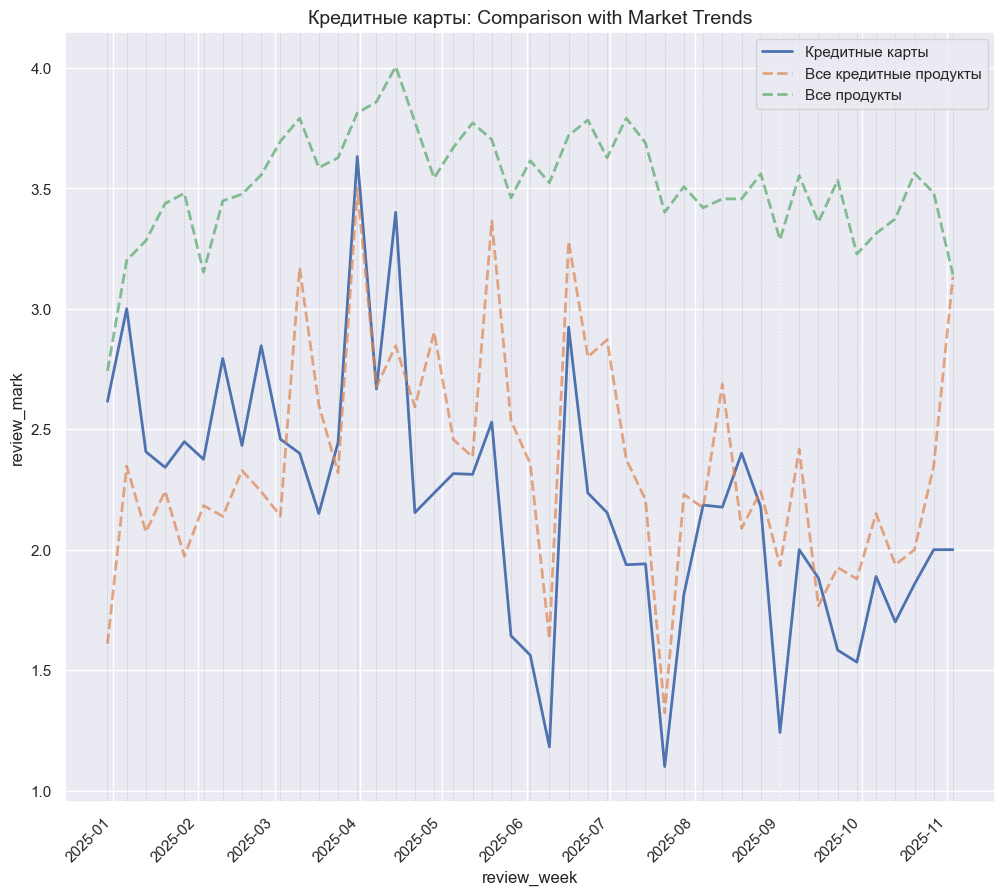

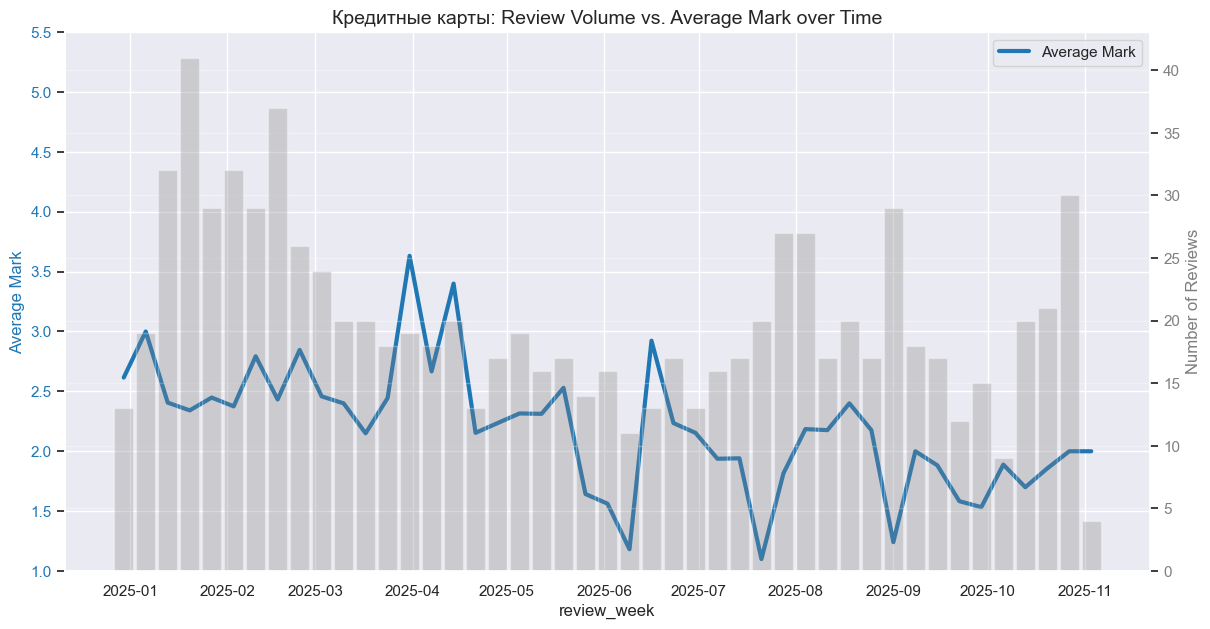

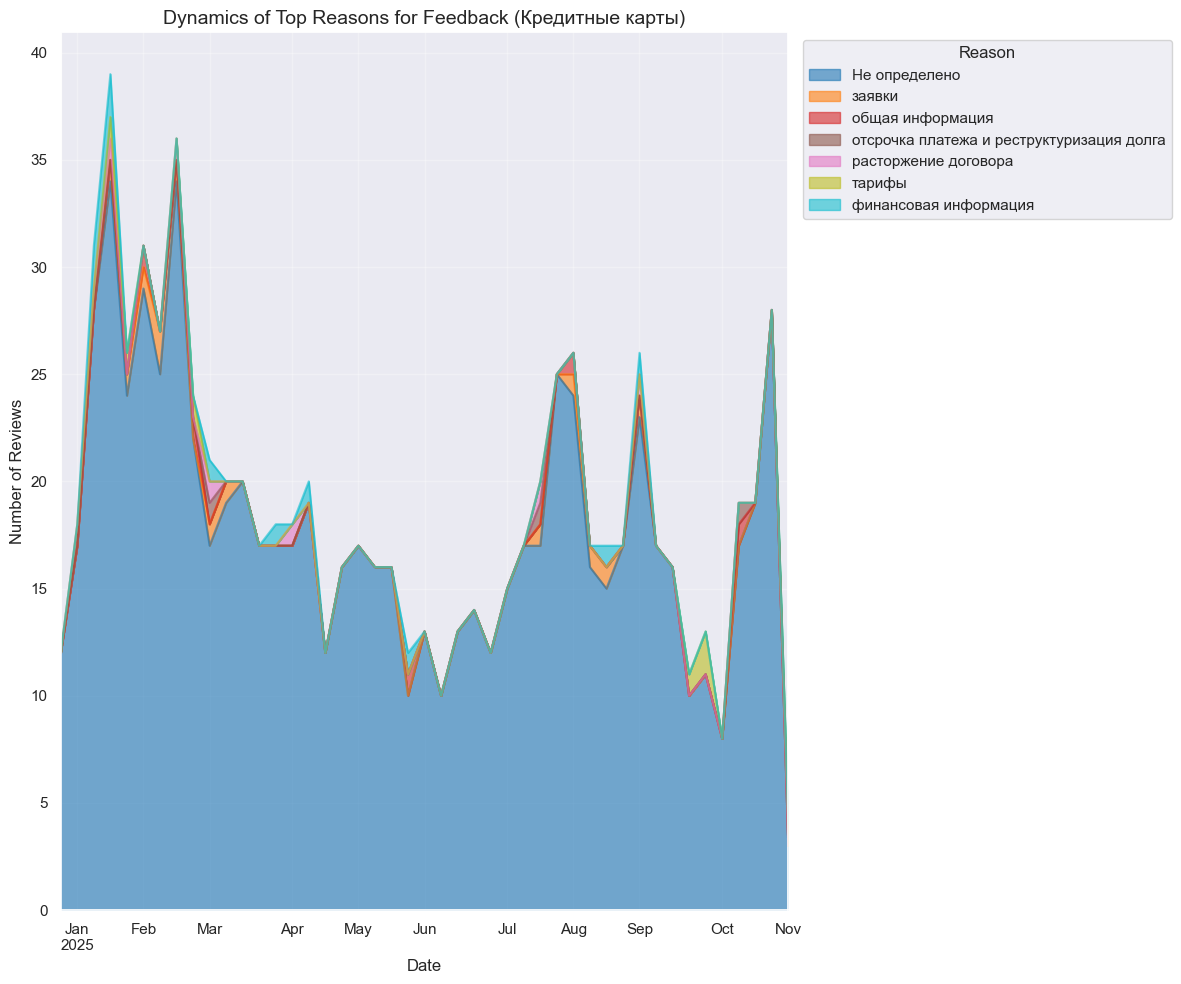

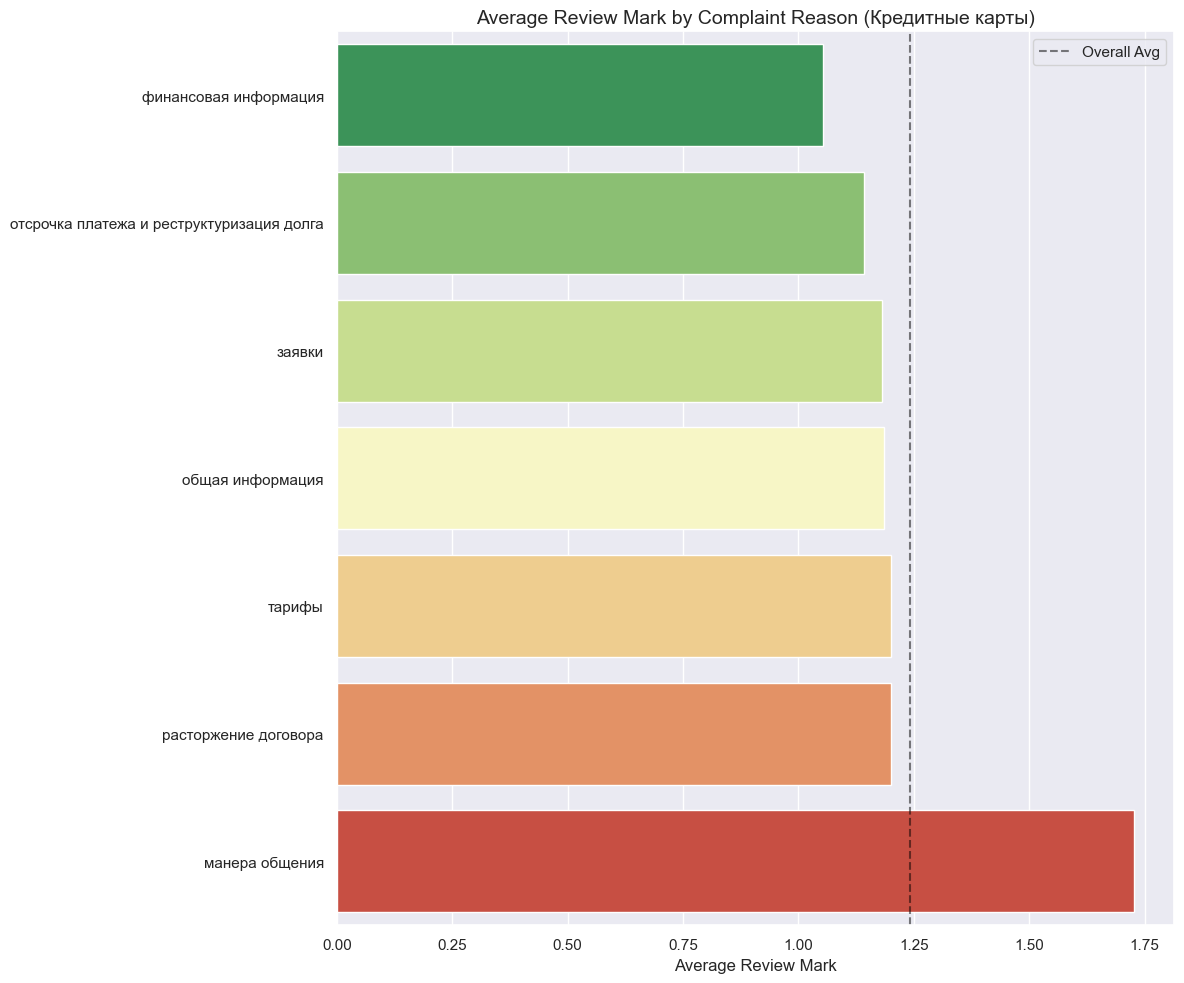

,product,reviews,neg_share,csat_mean,solved_share,handle_median
3,Кредитные карты,3065,0.730506,1.58147,0.446982,1.744462



Кредитные карты: segment_name


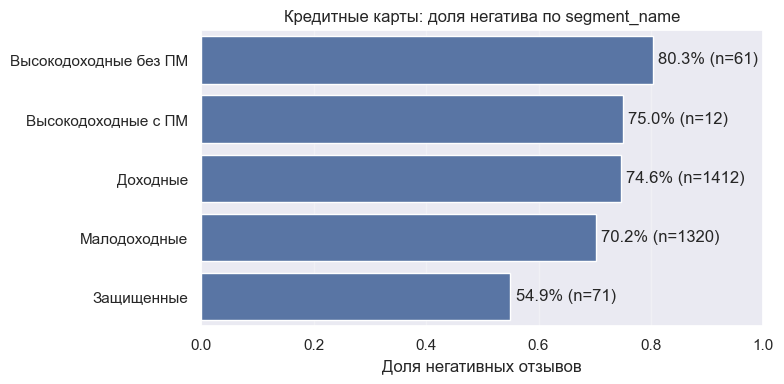

,segment_name,neg_share,n
0,Высокодоходные без ПМ,0.803279,61
1,Высокодоходные с ПМ,0.750000,12
2,Доходные,0.746459,1412
4,Малодоходные,0.701515,1320
3,Защищенные,0.549296,71



Кредитные карты: age_segment


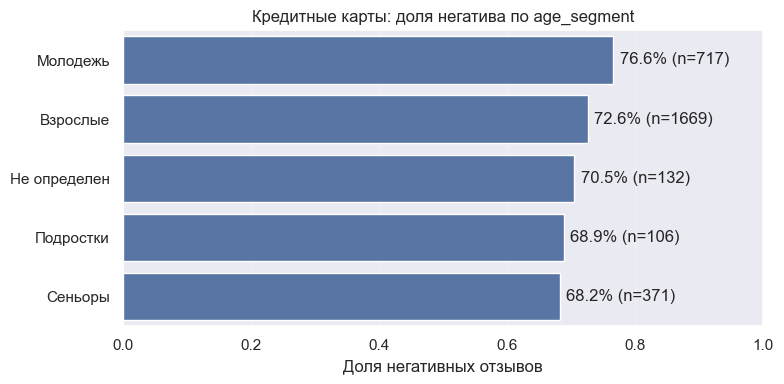

,age_segment,neg_share,n
1,Молодежь,0.765690,717
0,Взрослые,0.726183,1669
2,Не определен,0.704545,132
3,Подростки,0.688679,106
4,Сеньоры,0.681941,371



Кредитные карты: gender_cd


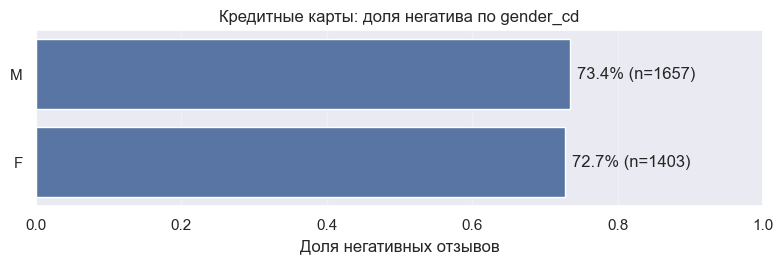

,gender_cd,neg_share,n
1,M,0.734460,1657
0,F,0.727014,1403



Кредитные карты: new_flg


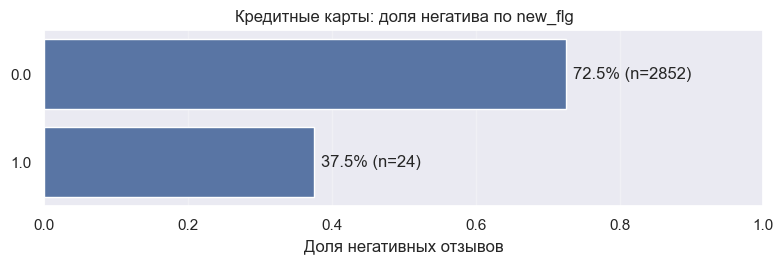

,new_flg,neg_share,n
0,0.0,0.725105,2852
1,1.0,0.375000,24



Кредитные карты: children_cnt


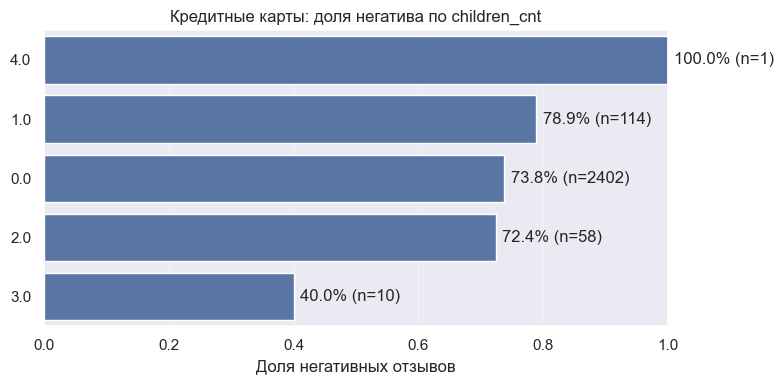

,children_cnt,neg_share,n
4,4.0,1.000000,1
1,1.0,0.789474,114
0,0.0,0.738135,2402
2,2.0,0.724138,58
3,3.0,0.400000,10


/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_90420/129162131.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("handle_bucket")


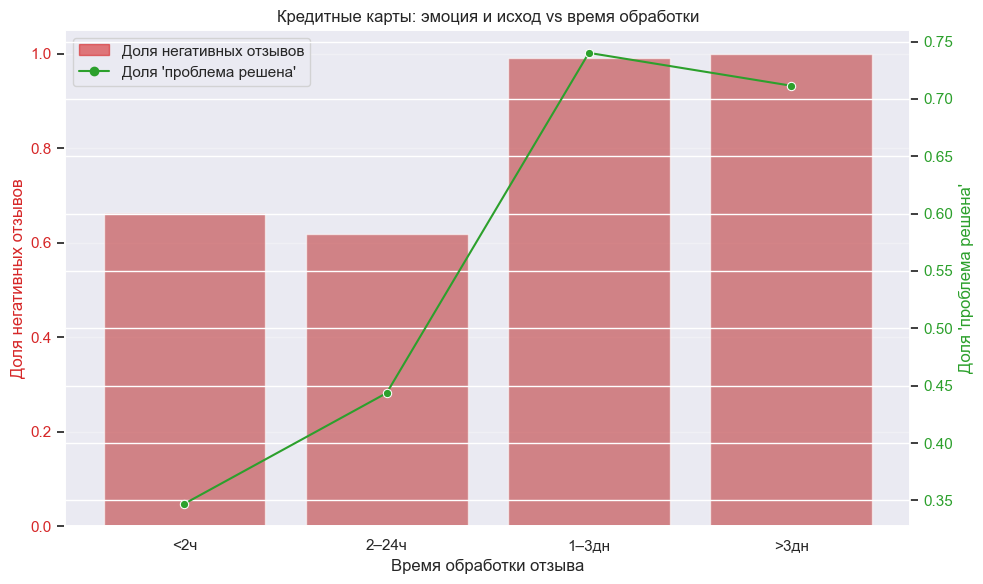

,handle_bucket,neg_share,solved_share,n
0,<2ч,0.663774,0.347072,461
1,2–24ч,0.618677,0.443580,257
2,1–3дн,0.992126,0.740157,127
3,>3дн,1.000000,0.711538,52


In [13]:
analyze_credit_product_extended(df, "Кредитные карты")

54723